# [Part 0] 환경 설정 및 모듈 import
학습 환경 : Google Colab  
데이터셋 저장 드라이브 : Google drive  
사용 GPU : Tesla P100  
코드 검수 : 방진혁, 권은빈

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# [Part 1] 레고 데이터 수집 (웹크롤링)  
사용 모듈 : Selenium

### 0. structure-flow

1. 페이지 접속
2. 페이지에서 ul 컨테이너를 찾는다. class="products columns-3"
3. ul 컨테이너 내부에 각 div로 total-product-image-wrap class를 찾는다
페이지당 이미지는 최대 21개이다. if문으로 21인 경우, 다음 페이지로 넘어가도록 설계하자
4. a href를 따라가서 두번째 이미지의 xpath를 찾는다.
5. 이미지를 수집하고 다시 이전 페이지로 돌아간다.
6. cnt로 현재까지 수집한 이미지의 개수를 센 다음에, % 나머지 값을 구해서 다음 페이지로 넘어간다

1->2->(3->4->5->6)과정 반복


### 1. 웹 크롤링 모듈 불러오기 (webdriver + Selenium + BeautifulSoup)

In [ ]:
# selenium settings
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver import ActionChains
from urllib.request import urlopen
from urllib.parse import quote_plus
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import urllib
import os

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', options=chrome_options)

### 2. 이미지 url 가져오기

In [ ]:
base_url = 'https://minifigs.blog/collection/'
cnt = 100
driver.get(base_url)

In [ ]:
# 드라이버 새로고침, 화면 로드 지연 해결
common_path1 = '//*[@id="primary"]/ul/li'
common_path2 = '/div[1]/a'
#수집하고자 하는 이미지 url 담는 리스트
image_url_list = []

def find_lego(page, idx):
    #collections내 레고 이미지 순차적으로 탐색
    img_container = driver.find_element(by=By.XPATH, value=common_path1 + "[{idx}]".format(idx = str(idx)) + common_path2)

    img_container.click()
    driver.switch_to.frame(0)
    #정보 페이지에서 10도 간격으로 시점을 이동하는 이미지 선택
    for i in range(1, 37):
      second_img_path = '/html/body/div[2]/div[1]/img[{i}]'.format(i=i)
      lego = driver.find_element(by=By.XPATH, value=second_img_path)
      lego = lego.get_attribute('src')
      image_url_list.append(lego) #이미지 경로 수집 완료
    print("현재 페이지 :", page+1, idx, "현재 수집하는 레고 이미지 경로 :", lego)
    

    #페이지 이전으로 이동하기
    driver.back()
    time.sleep(1)

In [ ]:
for i in range(0, cnt):
  current_page = i // 21
  if i < 21: #20까지는 동일한 페이지 내에 존재하는 이미지 수집
    driver.refresh()
    time.sleep(1)

    find_lego(current_page, i+1)
  elif i >= 21 and i % 21 == 0:
    #페이지 다음으로 이동하기
    driver.refresh()
    time.sleep(1)

    #ul의 마지막 자식 노드를 탐색(>)
    next_num = '/html/body/div[1]/div/div/div[1]/nav/ul/li[last()]/a'
    try:
      page_next = driver.find_element(by=By.XPATH, value=next_num)
    except:
      break
    page_next.click()
    find_lego(current_page, i % 21 +1)
  else:
    driver.refresh()
    time.sleep(1)

    find_lego(current_page, i % 21 +1)

### 3. 이미지 구글 드라이브에 저장

In [ ]:
#레고 이미지 저장 경로
if not os.path.exists("/content/drive/MyDrive/images"):
    os.makedirs("/content/drive/MyDrive/images")

In [ ]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-Agent','Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
urllib.request.install_opener(opener)

In [ ]:
# 이미지 저장
img_num = 0
count = 0
err_img_url = []
keyword = 'lego'

for n, i in enumerate(image_url_list):
  try:
    if count == 0:
      img_num += 1
    urllib.request.urlretrieve(i, "/content/drive/MyDrive/images/{0}_{1}_{2}.jpg".format(keyword, img_num, count))
    if count == 35:
      count = 0
    else:
      count += 1
    if n!=0 and n%36==0:
        print(n/36, "/", len(image_url_list) / 36, "개 완료")
  except:
    err_img_url.append(i)
    print("error 발생으로 수집안됨 (번호: %d)" % n)   # 주로 503 error, error 발생시 수동으로 이미지 저장 (  img_url[error No.]  )
print('\n저장된 이미지 개수 :', img_num, '\n')
print('에러 이미지 URL:')
for i in err_img_url:
    print(i)

# [Part 2] 이미지 데이터 전처리

### 1. 이미지 윤곽선으로 사이즈 조절

In [ ]:
import cv2 #Opencv
from google.colab.patches import cv2_imshow
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#레고 이미지 저장 경로
if not os.path.exists("/content/drive/MyDrive/resize_hand"):
    os.makedirs("/content/drive/MyDrive/resize_hand")
if not os.path.exists("/content/drive/MyDrive/resize_foot"):
    os.makedirs("/content/drive/MyDrive/resize_foot")

In [ ]:
def image_resize_hand(img_url, output_url):
  src = cv2.imread(img_url, cv2.IMREAD_COLOR)

  #정면을 기준으로 자른다
  gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gray, ksize=(3,3), sigmaX=0) #가우시안 블러를 사용하여
  edged = cv2.Canny(blur, 10, 250) #외곽선을 찾는다
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
  closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
  ret, binary = cv2.threshold(edged, 127, 255, cv2.THRESH_TOZERO) #closed기준으로 외곽선 추출시 이미지 가장자리 윤곽선또한 포함되는 문제 발생, blur기준으로 진행
  binary = cv2.bitwise_not(binary)

  contours, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS) #cv2.findContours(이진화 이미지, 검색 방법, 근사화 방법)

  #hierarchy는 [다음 윤곽선, 이전 윤곽선, 내곽 윤곽선, 외곽 윤곽선]의 형태로 값이 저장 되어 있다
  for i in range(len(contours)):
    cv2.drawContours(src, [contours[i]], 0, (0, 255, 0), 2) #cv2.drawContours(이미지, [윤곽선], 윤곽선 인덱스, (B, G, R), 두께, 선형 타입)
    cv2.putText(src, str(i), tuple(contours[i][0][0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1)
  
  contours_xy = np.array(contours)

  hand_x_min, hand_x_max = float('inf'), float('-inf')
  hand_y_left, hand_y_right = 0, 0
  for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      if not contours_xy[i][j][0][0] == 0 and hand_x_min > contours_xy[i][j][0][0]:
        hand_x_min = contours_xy[i][j][0][0]
        hand_y_left = contours_xy[i][j][0][1]
      if not contours_xy[i][j][0][0] == 500 and hand_x_max < contours_xy[i][j][0][0]:
        hand_x_max = contours_xy[i][j][0][0]
        hand_y_right = contours_xy[i][j][0][1]
    

  y_min, y_max = 0,0
  value = list()
  for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 y의 값
  value.sort()
  y_min = value[2]
  y_max = value[-3]

  x = hand_x_max - hand_x_min #가로길이
  if x > 256:
    avg_x = x - 256
    hand_x_max -= avg_x / 2
    hand_x_min += avg_x / 2
  elif x < 256:
    avg_x = 256 - x
    hand_x_max += avg_x / 2
    hand_x_min -= avg_x / 2

  hand_x_max = int(round(hand_x_max))
  hand_x_min = int(round(hand_x_min))
  x = hand_x_max - hand_x_min

  hand_y_max = max(hand_y_left, hand_y_right) - 160 #상체 길이 160
  hand_y = hand_y_max - y_min
  if hand_y > 256:
    avg_y = hand_y - 256
    hand_y_max -= avg_y / 2
    y_min += avg_y / 2
  elif hand_y < 256:
    avg_y = 256 - hand_y
    hand_y_max += avg_y / 2
    y_min -= avg_y / 2

  hand_y_max = int(round(hand_y_max))
  y_min = int(round(y_min))
  hand_y = hand_y_max - y_min

  dst = cv2.imread(img_url, cv2.IMREAD_COLOR)
  img_trim = dst[y_min:hand_y_max, hand_x_min:hand_x_max]
  cv2.imwrite(output_url, img_trim)

In [ ]:
def image_resize_foot(img_url, output_url):
  src = cv2.imread(img_url, cv2.IMREAD_COLOR)

  #정면을 기준으로 자른다
  gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gray, ksize=(3,3), sigmaX=0) #가우시안 블러를 사용하여
  edged = cv2.Canny(blur, 10, 250) #외곽선을 찾는다
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
  closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
  ret, binary = cv2.threshold(edged, 127, 255, cv2.THRESH_TOZERO) #closed기준으로 외곽선 추출시 이미지 가장자리 윤곽선또한 포함되는 문제 발생, blur기준으로 진행
  binary = cv2.bitwise_not(binary)

  contours, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS) #cv2.findContours(이진화 이미지, 검색 방법, 근사화 방법)

  #hierarchy는 [다음 윤곽선, 이전 윤곽선, 내곽 윤곽선, 외곽 윤곽선]의 형태로 값이 저장 되어 있다
  for i in range(len(contours)):
    cv2.drawContours(src, [contours[i]], 0, (0, 255, 0), 2) #cv2.drawContours(이미지, [윤곽선], 윤곽선 인덱스, (B, G, R), 두께, 선형 타입)
    cv2.putText(src, str(i), tuple(contours[i][0][0]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1)
  
  contours_xy = np.array(contours)

  hand_x_min, hand_x_max = float('inf'), float('-inf')
  hand_y_left, hand_y_right = 0, 0
  for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      if not contours_xy[i][j][0][0] == 0 and hand_x_min > contours_xy[i][j][0][0]:
        hand_x_min = contours_xy[i][j][0][0]
        hand_y_left = contours_xy[i][j][0][1]
      if not contours_xy[i][j][0][0] == 500 and hand_x_max < contours_xy[i][j][0][0]:
        hand_x_max = contours_xy[i][j][0][0]
        hand_y_right = contours_xy[i][j][0][1]
    

  y_min, y_max = 0,0
  value = list()
  for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
      value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 y의 값
  value.sort()
  y_min = value[2]
  y_max = value[-3]

  x = hand_x_max - hand_x_min #가로길이
  if x > 256:
    avg_x = x - 256
    hand_x_max -= avg_x / 2
    hand_x_min += avg_x / 2
  elif x < 256:
    avg_x = 256 - x
    hand_x_max += avg_x / 2
    hand_x_min -= avg_x / 2

  hand_x_max = int(round(hand_x_max))
  hand_x_min = int(round(hand_x_min))
  x = hand_x_max - hand_x_min

  point_y = (y_max + y_min) / 2 #중간 지점 찾기
  point_y = int(point_y)

  w = (point_y - y_min) / 4 #머리부터 중간 지점까지의 1/4값을 찾는다
  w = int(w)
  #y_min + w부터 : point_y + w까지, 했는데 만약 길이가 256고정이 아니라면 조금씩 조정하기
  new_y_min = y_min + w
  new_y_max = point_y + w
  y = new_y_max - new_y_min
  if y > 256:
    avg_y = y - 256
    new_y_max -= avg_y / 2
    new_y_min += avg_y / 2
  elif y < 256:
    avg_y = 256 - y
    new_y_max += avg_y / 2
    new_y_min -= avg_y / 2

  new_y_max = int(round(new_y_max))
  new_y_min = int(round(new_y_min))
  y = new_y_max - new_y_min

  dst = cv2.imread(img_url, cv2.IMREAD_COLOR)
  img_trim = dst[new_y_min:new_y_max, hand_x_min:hand_x_max]
  cv2.imwrite(output_url, img_trim)

In [ ]:
error_hand = []
for i in range(1, 101):
  for j in range(36):
    img_url = '/content/drive/MyDrive/images/lego_{i}_{j}.jpg'.format(i=i, j=j)
    try:
      output_url = '/content/drive/MyDrive/resize_hand/lego_{i}_{j}.jpg'.format(i=i, j=j)
      image_resize_hand(img_url, output_url) #레고 사이즈 일관적
    except:
      error_hand.append([i, j])
      continue
  print(i,"번째 레고 이미지 전처리 완료")
print("-" * 50)
print(len(error_hand),"개 문제 발생")

In [ ]:
error_foot = []
for i in range(1, 101):
  for j in range(36):
    img_url = '/content/drive/MyDrive/images/lego_{i}_{j}.jpg'.format(i=i, j=j)
    try:
      output_url = '/content/drive/MyDrive/resize_foot/lego_{i}_{j}.jpg'.format(i=i, j=j)
      image_resize_foot(img_url, output_url) #레고 사이즈 일관적
    except:
      error_foot.append([i, j])
      continue
  print(i,"번째 레고 이미지 전처리 완료")
print("-" * 50)
print(len(error_foot),"개 문제 발생")

> 이 단계 이후 resize_hand와 resize_foot 폴더 내 존재하는 이미지 중 정면 사진이면서 얼굴 위치가 이미지 가운데에 위치한 이미지만 추출  
> 추출한 이미지는 lego_mugshots라는 이름의 폴더 내에 저장함

# [Part 3] StyleGAN2 + ada 모델링

### 1. mahotas library로 이미지 유사도 판별

In [ ]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 5.4 MB/s 


In [ ]:
import cv2 #Opencv
from google.colab.patches import cv2_imshow
import os
import numpy as np
import sklearn
from glob import glob
import mahotas as mh
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from PIL import Image
from scipy.spatial  import distance
%matplotlib inline

> 해르미온느 사진과 헤르미온느 레고 사진은 임의로 구글에서 검색하여 가져옴  
> 저장한 헤르미온느 사진은 mapping이라는 폴더 내에 저장함  
> 해리 포터, 스네이프 교수 사진 또한 가져옴  
> 두번째 이미지는 harry_potter 폴더 구성

> 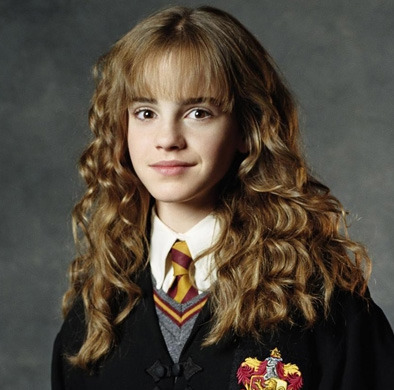
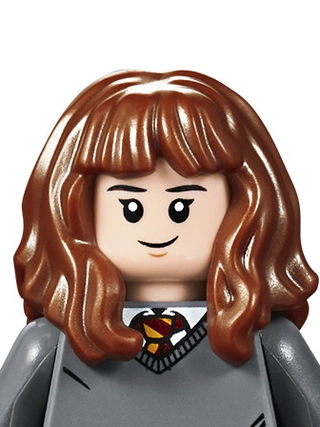

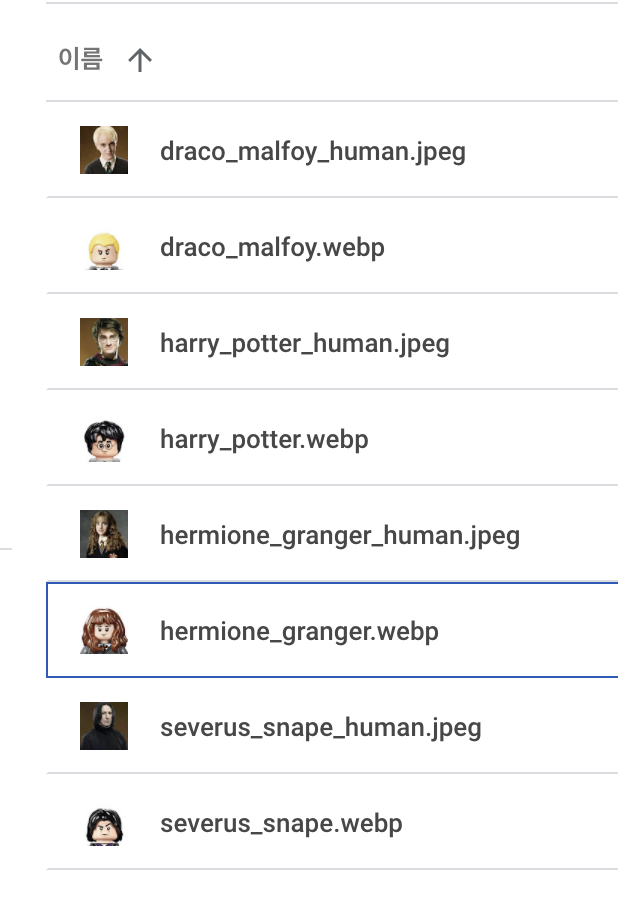

In [ ]:
images = glob('/content/drive/MyDrive/mapping/hermione_granger_human.jpeg')
images.extend(glob('/content/drive/MyDrive/mapping/*.webp'))
images[:]

In [ ]:
im = mh.imread(images[0])
im = mh.colors.rgb2gray(im, dtype=np.uint8)

In [ ]:
def chist(im):
    im = im // 64
    r, g, b = im.transpose((2, 0, 1))
    
    pixels = 1*r + 4*g + 16*b
    hist = np.bincount(pixels.ravel(), minlength=64)
    hist = hist.astype(float)
    return np.log1p(hist)    

In [ ]:
features = []
for im in images:
    imcolor = mh.imread(im)
    imcolor = imcolor[50:-50, 50:-50] #이미지의 외곽선에 가까운 값 처리하기
    im = mh.colors.rgb2gray(imcolor, dtype=np.uint8)
    features.append(np.concatenate([mh.features.haralick(im).ravel(), chist(imcolor),])) #haralick

In [ ]:
sc = MinMaxScaler()
features = sc.fit_transform(features)
dists = distance.squareform(distance.pdist(features))

In [ ]:
def selectImage( n, m, dists, images):
    image_position = dists[n].argsort()[m]
    image = mh.imread(images[image_position])
    return image

def plotImages(n):
    plt.figure(figsize=(15, 15))
    
    plt.subplot(141)
    plt.imshow(selectImage(n, 0, dists, images))
    plt.title('Original')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(142)
    plt.imshow(selectImage(n, 1, dists, images))
    plt.title('1st similar one')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(143)
    plt.imshow(selectImage(n, 2, dists, images))
    plt.title('2nd similar one')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(144)
    plt.imshow(selectImage(n, 3, dists, images))
    plt.title('3rd similar one')
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

In [ ]:
plotImages(0)

### 2. 이미지 256x256x3 으로 조절한 뒤 모델 학습

> jpeg 이미지를 jpg 확장자로 변경하여 모델 데이터로 활용함

In [ ]:
#해리 포터 시리즈의 이미지 사이즈 조절
images = list()
images.extend(glob('/content/drive/MyDrive/harry_potter/*.jpg'))
for url in images:
  src = cv2.imread(url, cv2.IMREAD_COLOR)
  dst = src[40:-67, :].copy()

  resize_img = cv2.resize(dst, (256, 256 ))
  cv2.imwrite(url, resize_img)

In [ ]:
if os.path.isdir('/content/drive/MyDrive/WIP/stylegan2-ada/'):
    %cd '/content/drive/MyDrive/WIP/stylegan2-ada/'
else:
    !git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/drive/MyDrive/WIP/stylegan2-ada/
    %cd '/content/drive/MyDrive/WIP/stylegan2-ada/'

In [ ]:
#데이터를 하나의 zip 형태로 묶음
!python dataset_tool.py \
--source=/content/drive/MyDrive/lego_mugshots \
--dest=/content/drive/MyDrive/WIP/stylegan2-ada/datasets/lego-256x256.zip

In [ ]:
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
from tqdm.notebook import tqdm

IMAGE_PATH = '/content/drive/MyDrive/lego_mugshots' #resize_hand 중 데이터셋으로 적합한 데이터를 추출함
files = [f for f in listdir(IMAGE_PATH) if isfile(join(IMAGE_PATH, f))]

base_size = None
for file in tqdm(files):
  file2 = os.path.join(IMAGE_PATH,file)
  img = Image.open(file2)
  sz = img.size
  if base_size and (sz != base_size):
    print(f"Inconsistant size: {file2}")
  elif img.mode != 'RGB':
    print(f"Inconsistant color format: {file2}")
  else:
    base_size = sz
print("check finish")
# 데이터셋으로 사용되는 이미지들의 사이즈가 동일한지 확인하기

In [ ]:
if os.path.isdir('/content/drive/MyDrive/WIP/stylegan2-ada/experiments'):
  pass
else:
  os.mkdir('/content/drive/MyDrive/WIP/stylegan2-ada/experiments')

In [ ]:
!pip install ninja
!pip install torch==1.8.1 torchvision==0.9.1

In [ ]:
import os

# snap 값 동안 학습을 하고 snap값 이후에는 fake image를 생성해서 model evaluation
EXPERIMENTS = "/content/drive/MyDrive/WIP/stylegan2-ada/experiments/"
DATA = "/content/drive/MyDrive/WIP/stylegan2-ada/datasets/lego-256x256.zip"
SNAP = 5
KIMG = 200
RESUME = "ffhq256"

# 모델 학습 시작
cmd = f"/usr/bin/python3 /content/drive/MyDrive/WIP/stylegan2-ada/train.py \
--snap {SNAP} \
--outdir {EXPERIMENTS} \
--data {DATA} \
--resume {RESUME} \
--kimg {KIMG}"
!{cmd}

### 3. 학습된 모델 pkl 파일로 이미지 seed 추출하기

In [ ]:
%cd /content/drive/MyDrive/WIP/stylegan2-ada

> 여러 번 시도를 통하여 만들어진 모델을 사용하여 시드 이미지를 생성해보기

In [ ]:
import os
EXPERIMENTS = "./experiments/"
FOLDER = "00007-lego-256x256-auto1-kimg80-resumeffhq256"
NETWORK = "network-snapshot-000080.pkl"
RESUME = os.path.join(EXPERIMENTS, FOLDER, NETWORK)

rows = 0
cols = 0
styles = 3
trunc = 1
noise = 'const'
outdir = 'out'

cmd = f"/usr/bin/python3 '/content/drive/MyDrive/WIP/stylegan2-ada/style_mixing.py' \
--network {RESUME} \
--rows {rows} \
--cols {cols} \
--styles {styles} \
--trunc {trunc} \
--noise-mode {noise} \
--outdir {outdir}"
!{cmd}

# [Part 4] Gradio로 웹 프로토타이핑

In [ ]:
!pip install gradio
!pip install ninja
!pip uninstall tensorflow
!pip install tensorflow==1.13.2

In [ ]:
%cd /content/drive/MyDrive/WIP/stylegan2-ada

In [ ]:
import cv2
import numpy as np
import os
import gradio as gr
import subprocess
from pprint import pprint
from pathlib import Path

EXPERIMENTS = "./experiments/"
FOLDER = "00007-lego-256x256-auto1-kimg80-resumeffhq256"
NETWORK = "network-snapshot-000080.pkl"
RESUME = os.path.join(EXPERIMENTS, FOLDER, NETWORK)
noise = 'const'

def model(input):
  if input[0][0][0] == 46:
    rows = 2
    cols = 8
  else:
    rows = 100
    cols = 100

  raw_path = "/content/drive/MyDrive/WIP/stylegan2-ada/style_mixing.py"
  print(f"{raw_path} exists: {Path(raw_path).exists()}")
  result = subprocess.run(
      [
        "python3",
        raw_path,
        "--network", f'{RESUME}',
        "--rows", f'{rows}',
        "--cols", f'{cols}',
        "--styles", "0",
        "--trunc", "1",
        "--noise-mode", f"{noise}",
        "--outdir", 'out'
      ],
      capture_output=True
    )
  pprint(result)

  output = cv2.imread(f'/content/drive/MyDrive/WIP/stylegan2-ada/out/{rows}-{cols}.png', cv2.IMREAD_COLOR)
  output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)
  return output

demo = gr.Interface(fn=model, inputs="image", outputs="image") # model 함수의 리턴은 이미지이여야 한다

demo.launch()